# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Step 0: Load Dependencies and Data

In [1]:
##### DAY 01 of SDC Traffic Sign Classifier: 03-27-20
import tensorflow as tf
import numpy as np
import random
from collections import Counter
import cv2
import pandas as pd
import pickle
from pandas import DataFrame
import sklearn
import sys
import os
from tqdm import tqdm
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import confu
# sion_matrix
import matplotlib.pyplot as plt
from math import ceil, pow
%matplotlib inline



In [2]:
# Load pickled data
# Load pickled data
# Load pickled data
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']
signnames = pd.read_csv('signnames.csv')['SignName']

print("x_train: {}, y_train {}".format(x_train.shape, y_train.shape))

assert(len(x_train) == len(y_train))
assert(len(x_valid) == len(y_valid))
assert(len(x_test) == len(y_test))


# display keys and  for training dict{}  
print(train.keys())
# Read in and display training data 
df = DataFrame(list(train.items()),columns = ['Data Keys','Values']) 
df.head()


x_train: (34799, 32, 32, 3), y_train (34799,)
dict_keys(['coords', 'labels', 'features', 'sizes'])


,Data Keys,Values
0,coords,"[[6, 5, 21, 20], [6, 6, 22, 22], [5, 6, 22, 23..."
1,labels,"[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4..."
2,features,"[[[[28 25 24], [27 24 23], [27 24 22], [27 24 ..."
3,sizes,"[[26, 25], [27, 27], [27, 28], [27, 28], [29, ..."


In [3]:
for key, value in train.items():
    print('{0}: {1}'.format(key, value))

coords: [[  6   5  21  20]
 [  6   6  22  22]
 [  5   6  22  23]
 ...
 [ 17  15 178 155]
 [ 17  15 183 160]
 [ 20  18 211 184]]
labels: [41 41 41 ... 25 25 25]
features: [[[[ 28  25  24]
   [ 27  24  23]
   [ 27  24  22]
   ...
   [ 32  28  24]
   [ 31  27  25]
   [ 31  27  26]]

  [[ 29  26  25]
   [ 27  25  23]
   [ 27  25  23]
   ...
   [ 32  28  24]
   [ 31  27  24]
   [ 30  27  25]]

  [[ 28  26  26]
   [ 27  25  23]
   [ 26  25  23]
   ...
   [ 32  28  24]
   [ 31  27  24]
   [ 30  27  25]]

  ...

  [[ 27  24  23]
   [ 28  25  24]
   [ 30  25  24]
   ...
   [ 27  24  23]
   [ 28  24  22]
   [ 29  25  22]]

  [[ 28  23  23]
   [ 29  24  24]
   [ 31  25  24]
   ...
   [ 27  24  23]
   [ 28  24  22]
   [ 28  24  21]]

  [[ 29  23  23]
   [ 30  24  24]
   [ 32  24  23]
   ...
   [ 27  24  22]
   [ 27  23  21]
   [ 26  22  20]]]


 [[[ 28  24  24]
   [ 26  23  23]
   [ 27  24  24]
   ...
   [ 31  28  26]
   [ 31  28  27]
   [ 32  28  27]]

  [[ 27  24  24]
   [ 27  24  24]
   [ 28  2

## Display Parameters and Helper Functions

In [4]:
A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    
    

def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    
    orig_idxes = []
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        orig_idxes.append(indx)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
#         plt.xlabel(signnames[dataset_y[indx]])
        plt.ylabel(signnames[dataset_y[indx]], fontsize=18)
#         plt.title(signnames[dataset_y[indx]], fontsize=18)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(y_train[indx], fontsize=18)
    plt.tight_layout(pad=0, h_pad=0, w_pad=5)
    plt.show()
    
    return orig_idxes
    
    

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [5]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = len(train['features'])
# Number of testing examples
n_test = len(test['features'])
# shape of an image?
image_shape = train['features'][0].shape
# number of classes are in the dataset
n_classes = np.max(train['labels']) + 1
# display keys and  for training dict{} 
# Sign types 
data_pd = pd.read_csv('signnames.csv')
signnames = pd.read_csv('signnames.csv')['SignName']
_, class_cnt = np.unique(y_train, return_counts = True)
data_pd['Counts'] = class_cnt


print("Image Shape: {}".format(x_train[0].shape))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(data_pd)


# Read in and display values for training keys
df = DataFrame(list(train.items()),columns = ['Data Keys','Values']) 
df.head()

Image Shape: (32, 32, 3)
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
    ClassId                                           SignName  Counts
0         0                               Speed limit (20km/h)     180
1         1                               Speed limit (30km/h)    1980
2         2                               Speed limit (50km/h)    2010
3         3                               Speed limit (60km/h)    1260
4         4                               Speed limit (70km/h)    1770
5         5                               Speed limit (80km/h)    1650
6         6                        End of speed limit (80km/h)     360
7         7                              Speed limit (100km/h)    1290
8         8                              Speed limit (120km/h)    1260
9         9                                         No passing    1320
10       10       No passing for vehicles over 3.5 metric tons    180

,Data Keys,Values
0,coords,"[[6, 5, 21, 20], [6, 6, 22, 22], [5, 6, 22, 23..."
1,labels,"[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4..."
2,features,"[[[[28 25 24], [27 24 23], [27 24 22], [27 24 ..."
3,sizes,"[[26, 25], [27, 27], [27, 28], [27, 28], [29, ..."


In [6]:
print(train['features'].shape)
print(train['labels'].shape)

(34799, 32, 32, 3)
(34799,)


## Exploring Dataset 

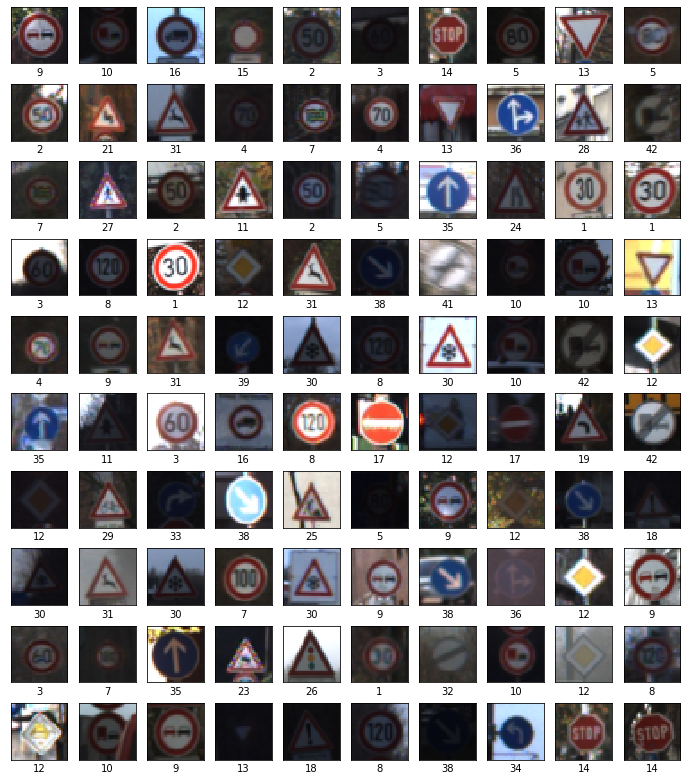

In [7]:
# Displaying a sample set of 100 from the data. 
def showRandomImages(gray = False):
    fig = plt.figure(figsize=(12, 14))
    for i in range(0, 100):
        number = np.random.randint(0, len(x_train))
        axis = fig.add_subplot(10,10,i+1)
        axis.set_xlabel(y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if not gray:
            axis.imshow(x_train[number])
        else:
            axis.imshow(x_train[number], cmap='gray')
    plt.show()

showRandomImages()

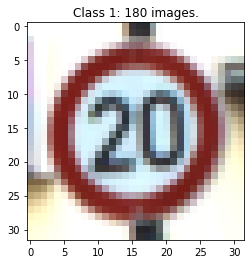

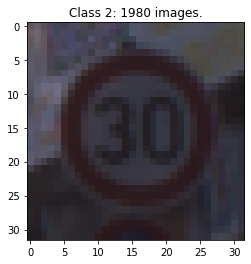

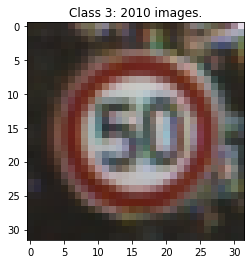

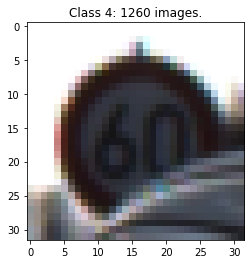

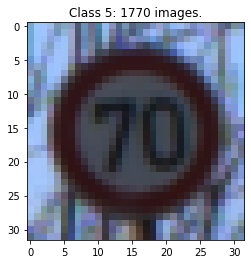

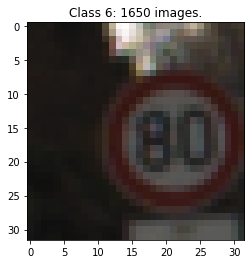

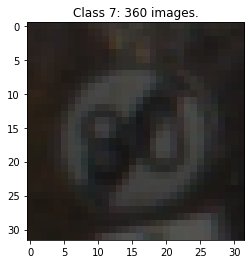

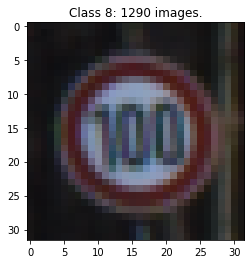

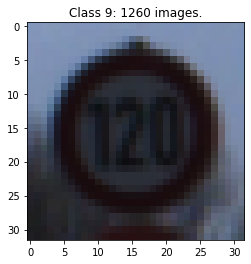

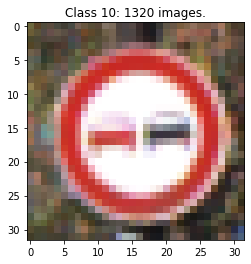

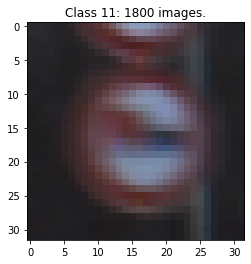

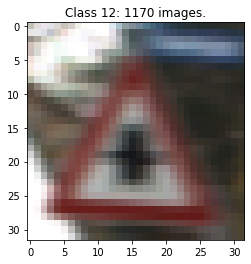

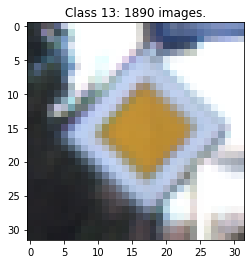

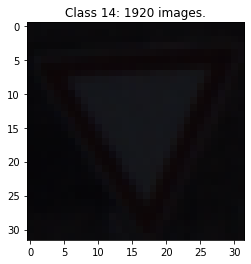

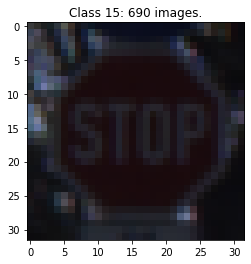

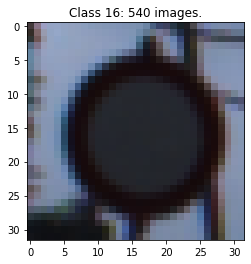

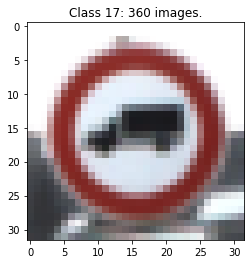

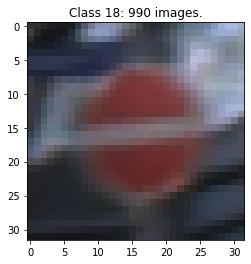

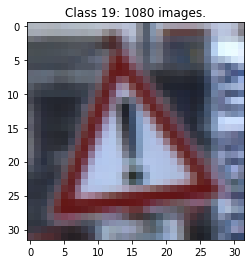

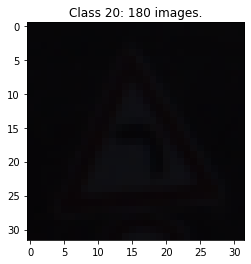

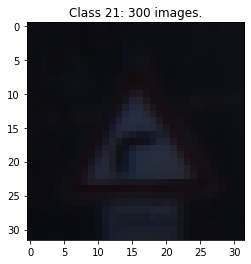

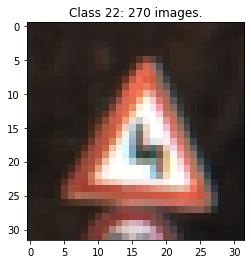

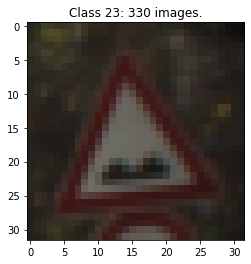

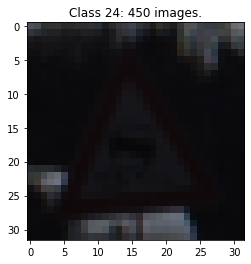

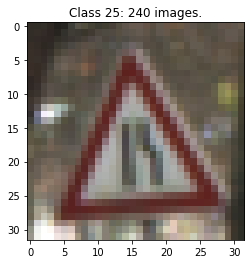

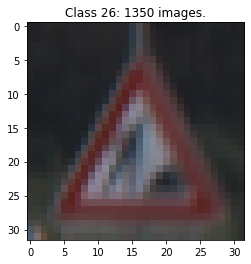

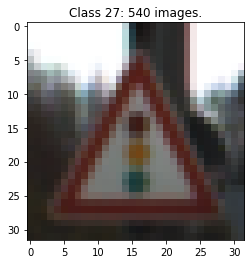

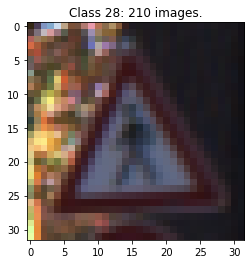

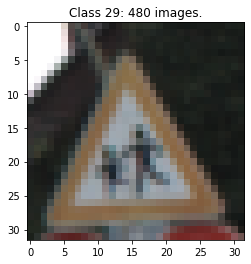

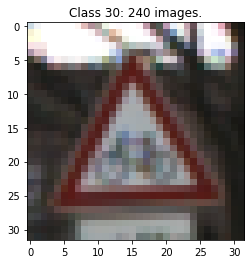

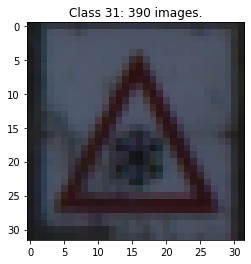

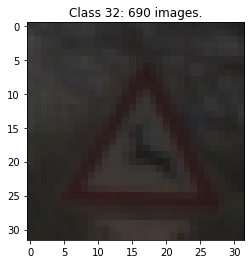

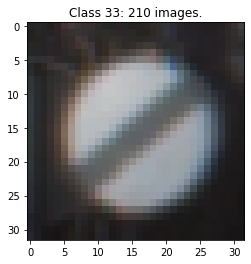

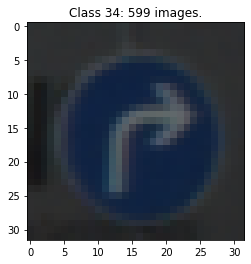

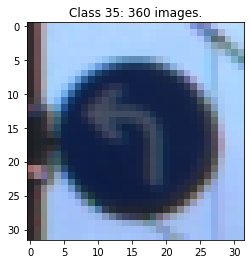

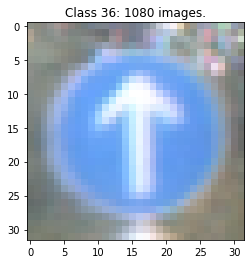

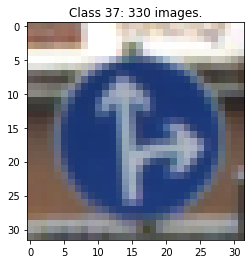

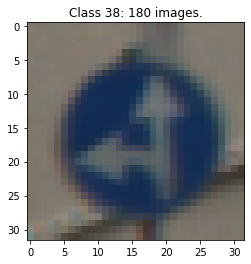

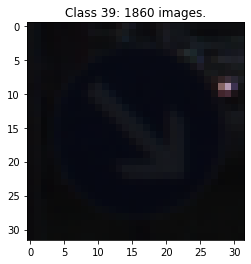

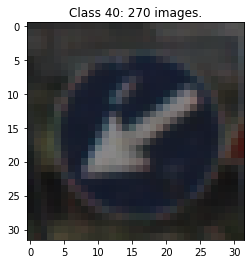

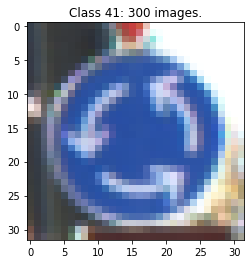

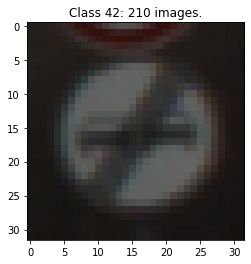

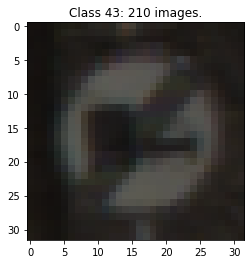

<class 'numpy.ndarray'>
(210, 1)


In [8]:
import matplotlib.pyplot as plt

# Show typical image for every class and the number of items in it.
num_per_class = np.zeros((n_classes,), dtype=int)
for i in range(n_classes):
    num_per_class[i] = np.sum(train['labels']==i)
    idxes = np.argwhere(train['labels']==i)
    plt.imshow(train['features'][idxes[20][0]])
    plt.title('Class %i: %i images.' % (i+1, num_per_class[i]))
    plt.show()
    
print(type(idxes))
print(idxes.shape)

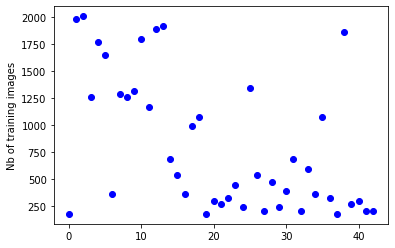

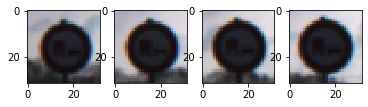

In [9]:
# Graph of the number of items per class
plt.plot(num_per_class, 'bo')
plt.ylabel('Nb of training images')
plt.show()

# Some blurry(!) images
num_plots = 4
delta = 17900
for i in range(num_plots):
    plt.subplot(1, num_plots, i+1)
    plt.imshow(train['features'][delta+i])
plt.show()



### Class Distribution 
    

C:\Users\empat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Most common index
index: 2 => Speed limit (50km/h) = 0.0591355252408731
index: 1 => Speed limit (30km/h) = 0.05825290546115858
index: 13 => Yield = 0.056487665901729524
index: 12 => Priority road = 0.055605046122015
index: 38 => Keep right = 0.05472242634230058
index: 10 => No passing for vehicles over 3.5 metric tons = 0.05295718678287143
index: 4 => Speed limit (70km/h) = 0.05207456700315691
index: 5 => Speed limit (80km/h) = 0.048544087884298814
index: 25 => Road work = 0.0397178900871535
index: 9 => No passing = 0.03883527030743905


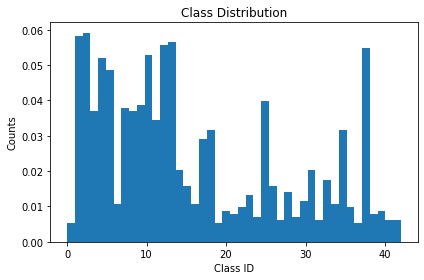

In [10]:
fig, ax = plt.subplots()
# the histogram of the data
values, bins, patches = ax.hist(y_train, n_classes, normed=10)

# add a 'best fit' line
ax.set_xlabel('Class ID')
plt.ylabel('Counts')
ax.set_title(r'Class Distribution')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()

print ("Most common index")
most_common_index = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
for index in most_common_index[:10]:
    print("index: %s => %s = %s" % (index, signnames[index], values[index]))

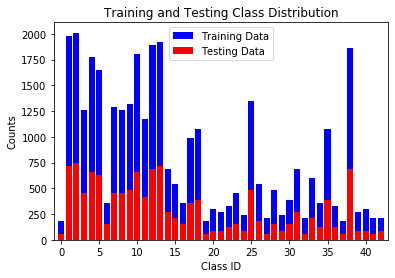

In [11]:
#Visualizes class distribution split between training and test datasets 
def showDistribution():
    _, training_counts = np.unique(y_train, return_counts = True)
    _, test_counts = np.unique(y_test, return_counts = True)
    plt.bar( np.arange( 43 ), training_counts, align='center',  color='b', label='Training Data')
    plt.bar( np.arange( 43 ), test_counts, align='center', color='r', label='Testing Data')
    plt.xlabel('Class ID')
    plt.ylabel('Counts')
    plt.title(r'Training and Testing Class Distribution')
    plt.xlim([-1, 43])
    plt.legend()
    plt.show()
    
showDistribution()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Pre-process Helper Functions 

In [12]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def grayscale(image):
    return cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))[0]

# includes additional reshaping to grayscale image
def convertToGray(image_data):
    image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)
    image_data = np.reshape(image_data, (32, 32, 1))
    return image_data

# def normalize(x):
#     min_val = np.min(x)
#     max_val = np.max(x)
#     x = (x-min_val) / (max_val-min_val)
#     return x
  
def normalize(image):
    mini, maxi = np.min(image), np.max(image)
    return (image - mini) / (maxi - mini) * 2 - 1

# Normalizing data and converting image dataset to grayscale 
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) ) **2


def equalize(image):

    return cv2.equalizeHist(image)


def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local


def one_hot_encode(x):
    encoded = np.zeros((len(x), 43))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
        
    return encoded

# def preprocess_im(image):
#     return np.expand_dims(normalize(equalize(image)), axis=2)

def preprocess_im(image):
    return np.expand_dims(normalize(image), axis=2)


def preprocess(dataset):
    return np.array([preprocess_im(im) for im in dataset])

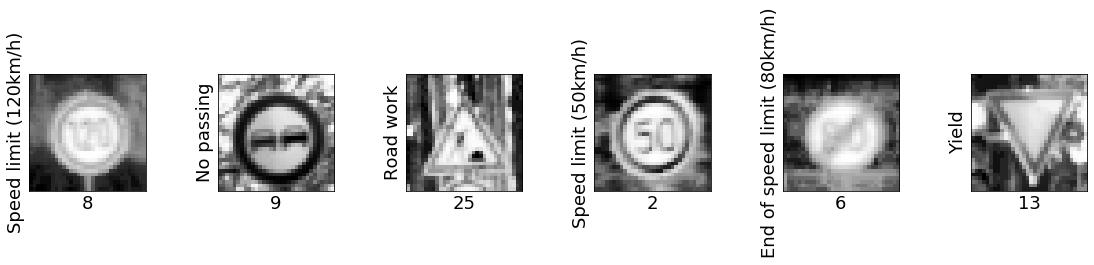

In [13]:
from PIL import Image
import numpy as np
idx = 510


def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

gray_images = list(map(gray_scale, x_train))
# list_images(gray_images, y_train, "Gray Scale image", "gray")

equalized_images = list(map(local_histo_equalize, gray_images))

# plt.imshow(train['features'][idx])
# plt.imshow(local_histo_equalize(train['features'][idx]))
orig_idxs = list_images(equalized_images, y_train, "", "gray")


### Single Transformation Functions


In [35]:
def rotate(image, angle=15, orientation='random'):
    if orientation == 'random':
        rotation_angle = random.choice([-angle, angle])
    elif orientation == 'left':
        rotation_angle = random_rot
    elif orientation == 'right':
        rotation_angle = -random_rot
    else:
        raise ValueError("Angle orientation will be random by defualt if not specified 'left' or 'right'")
    
    M = cv2.getRotationMatrix2D((16, 16), rotation_angle, 1)
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))


def translate(image, pixels=2):
    tx = np.random.choice(range(-pixels, pixels))
    ty = np.random.choice(range(-pixels, pixels))
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))


def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def scale(image, min=0.5, max=2.0): 
    n_row,n_col,channel = image.shape
    
    #Randomly select a rotation angle from the range passed.
    scale = np.random.uniform(min, max)
    
    M = cv2.getRotationMatrix2D((n_col/2,n_row/2), 0, scale)
    return cv2.warpAffine(image, M, (n_col, n_row))

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def perspect_transform(image, orientation='random'):
    
    n_row,n_col,channel = image.shape
    
    k=3 
    
    choices = [[5,5,5,5],
              [5,5,k,5+k]]
    choice = random.choice(choices)
    
    h_dstL = choice[0] #Horizontal distortion from the left
    h_dstR = choice[1] #Horizontal distortion from the right
    v_dstT = choice[2] #Vertical distortion from the top
    v_dstB = choice[3] #Vertical distortion from the bottom
    
    #Generate the point sets depending on the orientation passed.
    if orientation == 'random':
        orientation = random.choice(['left', 'right'])
    
    if orientation == 'left':
        pts1 = np.float32([[0,k],[n_col,k],[0,n_row-k],[n_col,n_row-k]])
        pts2 = np.float32([[h_dstL,v_dstT],[n_col-h_dstR,0],[h_dstL,n_row-v_dstB],[n_col-h_dstR,n_row]])
    elif orientation == 'right':
        pts1 = np.float32([[0,k],[n_col,k],[0,n_row-k],[n_col,n_row-k]])
        pts2 = np.float32([[h_dstL,0],[n_col-h_dstR,v_dstT],[h_dstL,n_row],[n_col-h_dstR,n_row-v_dstB]])
    else: raise ValueError("No or unknown orientation given. Possible values are 'left' and 'right'.")
    
    #Calculate the transformation matrix, perform the transformation, and return it.
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image, M, (n_row, n_col))


def brightness(image, min=0.5, max=2.0):
    #This sets the brightness to the max where any previous birghtness adjustments have exceeded the max. 
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_br = np.random.uniform(min,max)
    mask = hsv[:,:,2]*random_br > 255
    v_channel = np.where(mask, 255, hsv[:,:,2]*random_br)
    hsv[:,:,2] = v_channel
    
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)



def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

def random_bright(image):
    eff = 0.5 + np.random.random()
    return image * eff


def generate(images, count):
    generated = []
    while True:
        for image in images:
            if len(generated) == count:
                return generated
#             image = scale(image)
            image = random_bright(image)
            image = rotate(image)
            image = translate(image)
#             image = random_warp()
            image = normalize(image)
            image = local_histo_equalize(image)
            generated.append(np.expand_dims(image, axis=2))

### Combined Transformations 

In [15]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def rand_transform_v1(img, max_angle, scale_range):
    """Apply some random transform (rotation + scaling) to an image.

    Sample uniformly the transformation parameters.
    Used for data augmentation when converting to TFRecords.
    """
    rows, cols, chs = img.shape

    # Rotation and scaling. Note: reverse axis on OpenCV
    angle = np.random.uniform(low=-max_angle, high=max_angle)
    rot_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1.)
    img = cv2.warpAffine(img, rot_matrix, (cols, rows),
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)

    # Scaling matrix: keep image centered after scaled.
    scale_x = np.random.uniform(low=scale_range[0], high=scale_range[1])
    scale_y = np.random.uniform(low=scale_range[0], high=scale_range[1])
    scale_matrix = np.array([[scale_x, 0., (1. - scale_x) * cols / 2.], 
                             [0., scale_y, (1. - scale_y) * rows / 2.]], 
                            dtype=np.float32)
    img = cv2.warpAffine(img, scale_matrix, (cols, rows), 
                         flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)
    return img

def rand_transform_v2(img): 
#     img_transformed = np.array([rotate(translate(perspect_transform(image))) for image in train['features'][900:990]])
    img_transformed = np.array([rotate(translate(perspect_transform(img)))])

    return img


def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

### Sample of Transformations 

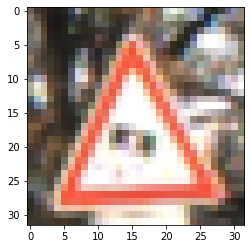

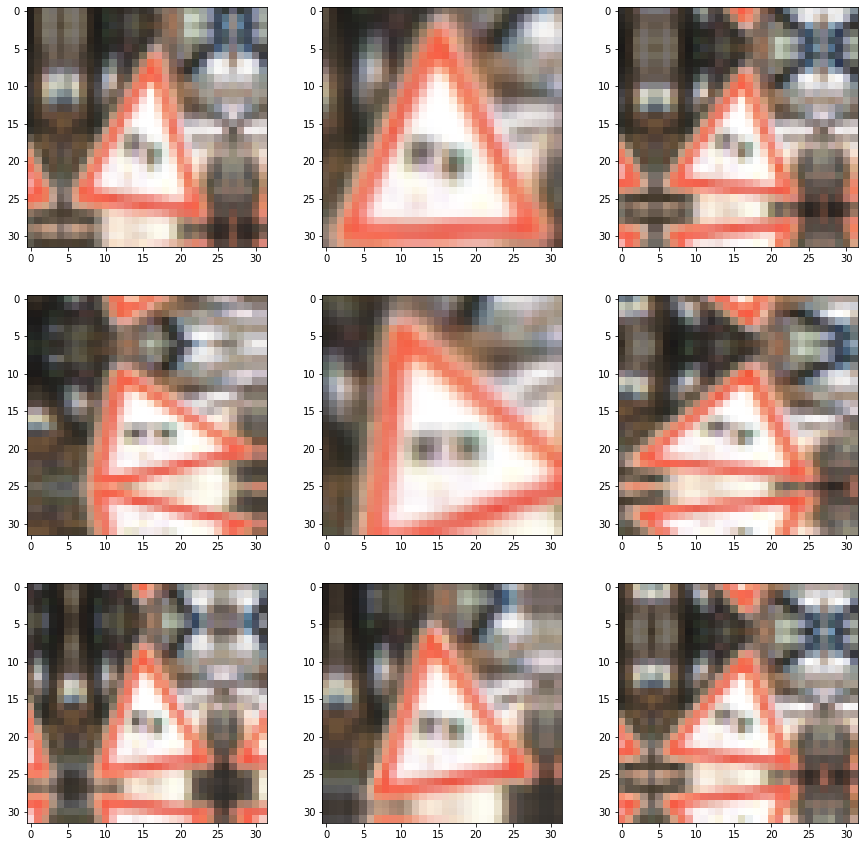

In [16]:
#Random Transformation Version 01 Sample 
idx = 2020
plt.imshow(train['features'][idx])
plt.show()

num_plots = 3

f, axs = plt.subplots(3,3,figsize=(15,15))

for i in range(num_plots**2):
    plt.subplot(num_plots, num_plots, i+1)
    plt.imshow(rand_transform_v1(train['features'][idx], 20., [0.6, 1.4]))
plt.show()

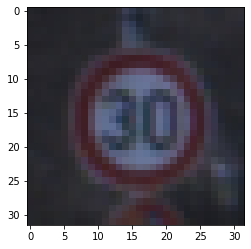

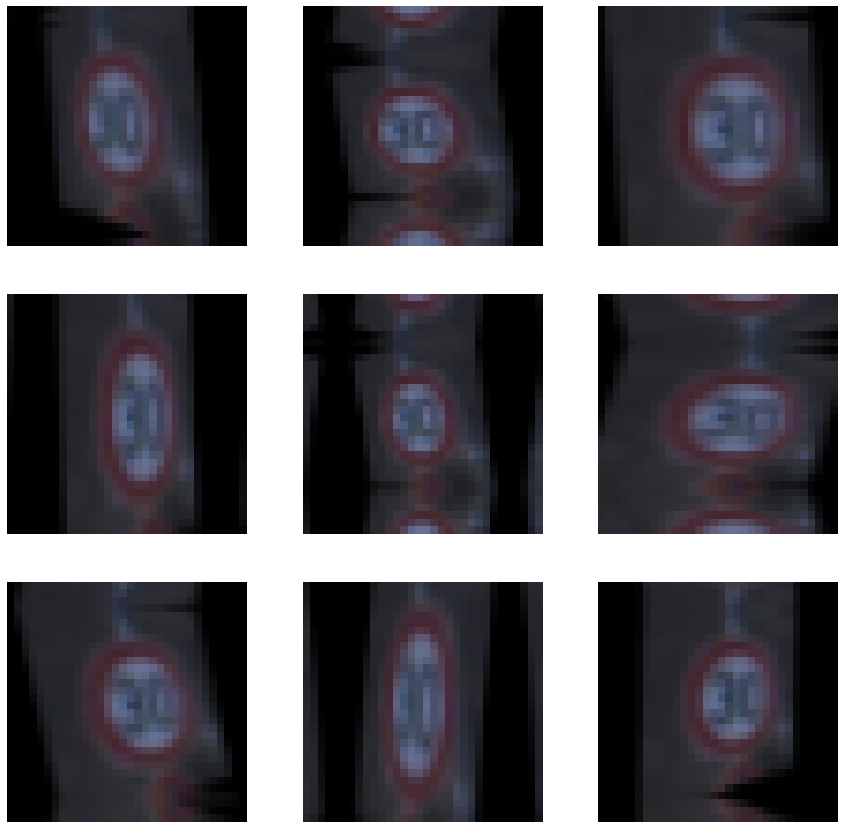

In [17]:
#Random Transformation Version 002
import matplotlib.pyplot as plt
import numpy as np

#Random Transformation Version 02 Sample 
idx = 4000
plt.imshow(train['features'][idx])
plt.show()

num_plots = 3
f, axs = plt.subplots(3,3,figsize=(15,15))

for i in range(num_plots**2):
    plt.subplot(num_plots, num_plots, i+1)
    plt.imshow(rand_transform_v1(perspect_transform(train['features'][idx]), 10., [0.6, 1.4]))
    plt.axis('off')
# plt.show()

### Pre-processing input data

In [18]:
"""
This preprocessing involves first 1) converting the images to the grayscale, reducing the 
depth of the input from three to one 2) normalizing the data, which is essentially changing the 
range of values to 

"""
x_train_n = preprocess(x_train)
x_valid_n = preprocess(x_valid)
x_test_n = preprocess(x_test)

In [19]:
# Convert train and test dataset images to grayscale
# Convert to grayscale
X_train_rgb = x_train
X_train_gry = np.sum(x_train/3, axis=3, keepdims=True)

X_test_rgb = x_test
X_test_gry = np.sum(x_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)



X_train = X_train_gry
X_test = X_test_gry

print(type(X_train))
print(X_train.shape)

RGB shape: (34799, 32, 32, 3)
Grayscale shape: (34799, 32, 32, 1)
<class 'numpy.ndarray'>
(34799, 32, 32, 1)


In [20]:
# Implement equalizeHist 


# gray_images = list(map(gray_scale, X_train))

# equalized_images = list(map(local_histo_equalize, X_train))


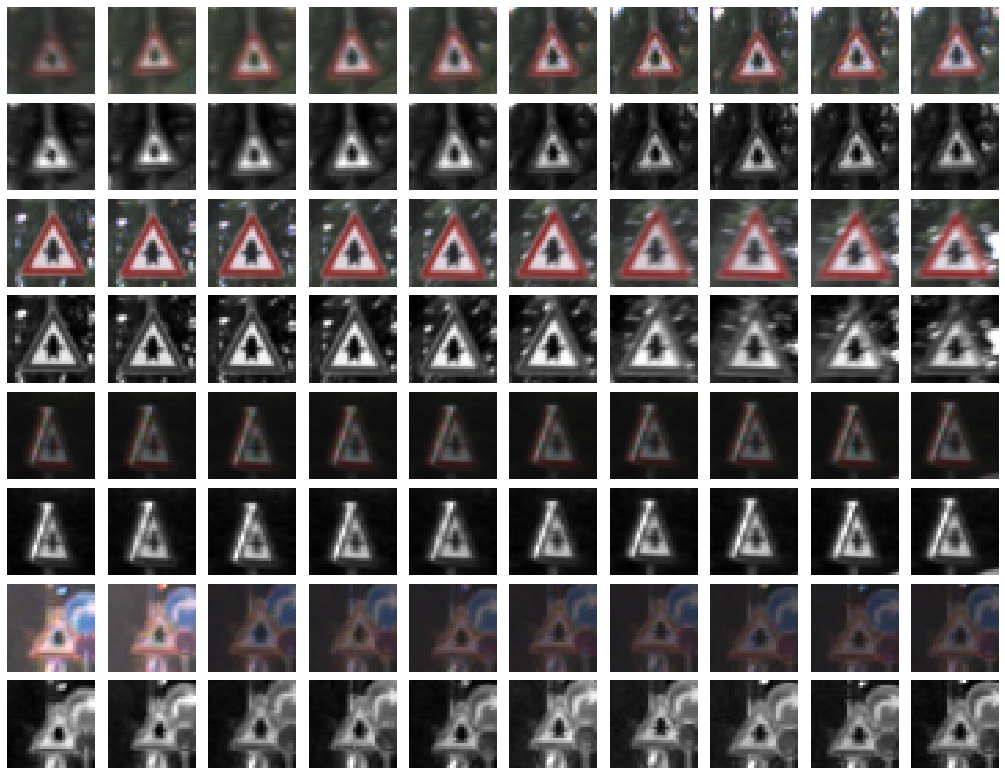

In [21]:

# Visualize rgb vs grayscale
n_rows = 8
n_cols = 10
offset = 9000
fig, axs = plt.subplots(n_rows,n_cols, figsize=(18, 14))
fig.subplots_adjust(hspace = .1, wspace=.001)
axs = axs.ravel()
for j in range(0,n_rows,2):
    for i in range(n_cols):
        index = i + j*n_cols
        image = X_train_rgb[index + offset]
        axs[index].axis('off')
        axs[index].imshow(image)
    for i in range(n_cols):
        index = i + j*n_cols + n_cols 
        image = X_train_gry[index + offset - n_cols].squeeze()
        axs[index].axis('off')
        axs[index].imshow(image, cmap='gray')

In [22]:
## Normalize the train and test datasets to (-1,1)

X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

print('X_train:', X_train.shape)
print('X_train_normalized:', X_train_normalized.shape)
print('X_train_normalized:', X_train_normalized.shape)

-0.35408133564846583
-0.3582151534281105
X_train: (34799, 32, 32, 1)
X_train_normalized: (34799, 32, 32, 1)
X_train_normalized: (34799, 32, 32, 1)


shape in/out: (32, 32, 1) (32, 32, 1)


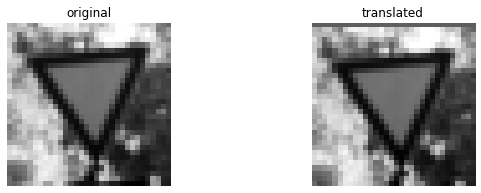

In [23]:
test_img = X_train_normalized[22222]

test_dst = random_translate(test_img)

fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].axis('off')
axs[0].imshow(test_img.squeeze(), cmap='gray')
axs[0].set_title('original')

axs[1].axis('off')
axs[1].imshow(test_dst.squeeze(), cmap='gray')
axs[1].set_title('translated')

print('shape in/out:', test_img.shape, test_dst.shape)

Original shape: (34799, 32, 32, 1)
Normalized shape: (34799, 32, 32, 1)


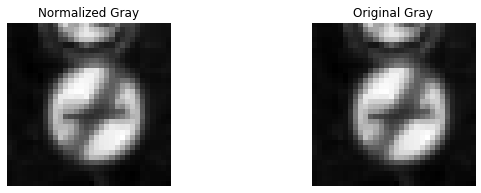

In [24]:
print("Original shape:", X_train.shape)
print("Normalized shape:", X_train_normalized.shape)
fig, axs = plt.subplots(1,2, figsize=(10, 3))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Normalized Gray')
axs[0].imshow(X_train_normalized[0].squeeze(), cmap='gray')

axs[1].axis('off')
axs[1].set_title('Original Gray')
axs[1].imshow(X_train[0].squeeze(), cmap='gray')

In [25]:
unique, counts = np.unique(y_train, return_counts=True)

target = 5000
x_augmented = []
y_augmented = []

for cls, count in tqdm(list(zip(unique, counts)), 'Augmenting training dataset'):
    diff = target - count
    x_augmented += generate(X_train_normalized[np.where(y_train == cls)[0]], diff)
    y_augmented += [cls for _ in range(diff)]

    
print("x_augmented", np.array(x_augmented).shape)    
print("y_augmented", np.array(y_augmented).shape)    
print("X_train_normalized", np.array(X_train).shape)    
print("y_train", np.array(y_train).shape)    

print()
X_train_normalized = np.concatenate([X_train_normalized, np.array(x_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])
n_train = y_train.size
print('Final number of training examples', n_train)

Augmenting training dataset: 100%|██████████| 43/43 [00:16<00:00,  2.60it/s]


x_augmented (180201, 32, 32, 1)
y_augmented (180201,)
X_train_normalized (34799, 32, 32, 1)
y_train (34799,)

Final number of training examples 215000


In [26]:

from sklearn.utils import shuffle

#Shuffle data
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
# x_valid_n, y_valid = shuffle(x_valid, y_valid)
# x_test_n, y_test = shuffle(x_test_n, y_test)

In [27]:

## Split validation dataset off from training dataset

from sklearn.model_selection import train_test_split

X_train_normalized, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(X_train))
print("New X_train size:",len(X_train))
print("X_validation size:",len(X_validation))

Old X_train size: 34799
New X_train size: 34799
X_validation size: 43000


## Model Architecture



### Version 001: LeNet

Relu Activation does not activate all neurons simultaneously  

In [28]:
from tensorflow.contrib.layers import flatten


def conv2d(x, kernel, input_depth, output_depth, stride=1, padding='VALID', mu=0, sigma=0.1):
    shape = (kernel, kernel, input_depth, output_depth)
    W = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_depth))
    conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    conv = tf.nn.bias_add(conv, b)
    return conv


def fully(x, input_size, output_size, mu=0, sigma=0.1):
    W = tf.Variable(tf.truncated_normal(shape=(input_size, output_size), mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_size))
    fc = tf.matmul(x, W)
    fc = tf.add(fc, b)
    return fc


def traffic_lenet(x):
    
    print("x", x.shape) #troubleshoot 
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    keep_prob = 0.5
    
    # SOLUTION: Layer 1: Convolution with a 3x3 kernel. Input = 32x32x1. Output = 30x30x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Relu Activation.
    conv1 = tf.nn.relu(conv1)
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 12, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(conv1, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
       
    conv1 = tf.nn.relu(conv1)

    print("conv1", conv1.shape) #troubleshoot 


    # SOLUTION: Pooling. Input = 28x28x6. Output = 
    conv1_max = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    print("conv1_max", conv1_max.shape) #troubleshoot 

    
    # SOLUTION: Layer 2: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 36), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(36))
    conv2   = tf.nn.conv2d(conv1_max, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: ReLu Activation.
    conv2 = tf.nn.relu(conv2)
    print("conv2",conv2.shape) #troubleshoot 

    
    # Conolution with 5x5 kernel. Input = 32x32x1. Output = 28x28x6.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 36, 48), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2   = tf.nn.conv2d(conv2, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
   
    conv2 = tf.nn.relu(conv2)

    print("conv2",conv2.shape) #troubleshoot 


    # SOLUTION: Pooling. 
    conv2_max = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    print("conv2_max", conv2_max.shape) #troubleshoot 

    # SOLUTION: Flatten. 
    conv1_flat   = tf.contrib.layers.flatten(conv1_max)
    conv2_flat   = tf.contrib.layers.flatten(conv2_max)
    flattened = tf.concat([conv1_flat,  conv2_flat], axis=1)

    # SOLUTION: Layer 3: Fully Connected. 
    fc1_W = tf.Variable(tf.truncated_normal(shape=(5136, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    
    print("flattened: {}, fc1_W: {}".format(flattened.shape, fc1_W.shape))
    
    fc1   = tf.matmul(flattened, fc1_W) + fc1_b # BUG HERE! 
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout to reduce variance 
    fc1 = tf.nn.dropout(fc1, keep_prob)

    print("fully1_dropout", fc1.shape) #troubleshoot 

    # SOLUTION: Layer 4: Fully Connected. 
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
   
    print("fc2_W: {}, fc2: {}".format(fc2_W.shape, fc2.shape))

          
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout to reduce variance 
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    
    # SOLUTION: Layer 5: Output Final Fully Connected
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    print("logits: ", logits.shape)
    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [29]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

## Training Pipeline

### Training Session 001

In [30]:
rate = 0.001

logits = traffic_lenet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

x (?, 32, 32, 1)
conv1 (?, 28, 28, 24)
conv1_max (?, 14, 14, 24)
conv2 (?, 10, 10, 36)
conv2 (?, 6, 6, 48)
conv2_max (?, 3, 3, 48)
Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.flatten instead.


flattened: (?, 5136), fc1_W: (5136, 512)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


fully1_dropout (?, 512)
fc2_W: (512, 256), fc2: (?, 256)
logits:  (?, 43)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [31]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [32]:
EPOCHS = 10
BATCH_SIZE = 32
keep_prob = 0.5

## Model Evaluation

In [33]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.795

EPOCH 2 ...
Validation Accuracy = 0.912

EPOCH 3 ...
Validation Accuracy = 0.951

EPOCH 4 ...
Validation Accuracy = 0.961

EPOCH 5 ...
Validation Accuracy = 0.968

EPOCH 6 ...
Validation Accuracy = 0.972

EPOCH 7 ...
Validation Accuracy = 0.970

EPOCH 8 ...
Validation Accuracy = 0.978

EPOCH 9 ...
Validation Accuracy = 0.980

EPOCH 10 ...
Validation Accuracy = 0.976

Model saved


In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train_n, y_train = shuffle(x_train_n, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train_n[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

## Model Method-Accuracy Log 

This is a record of the methods applied on the images and the resulting accuracy for each complete run. The notation "**std**" means only grayscale conversion and normalizing were used to preprocess the image. 


| Trial # |  Accuracy | Epoch/Total # | Transformation Method
|----------|:-------------:|:-------------:| :-------------:|
| 1    | 98.3% | 8/10  | std | 
| 2     |  97.9% | 10/10  | std+augment+random_translate | 
| 3      |  98.2% | 9/10| norm + grayscale + generator() w/norm  | 
| 4      |  97.6% | 10/10| norm + grayscale ~generator()| 
| 5      |  FILL IN HERE  | FILL IN HERE| FILL IN HERE  | 



In [ ]:
# Create augmented dataset with additional transformed images for each class 
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train_normalized.shape[0])
            new_img = X_train_normalized[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train_normalized = np.concatenate((X_train_normalized, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
#             if i % 50 == 0:
#                 print('|', end='')
#             elif i % 10 == 0:
#                 print('-',end='')
#     print('')
            
print('X, y shapes:', X_train_normalized.shape, y_train.shape)

### Version 003: Classical 2 Convolutions & 2 Fully Connected Layers 

In [ ]:
def conv2d(x, kernel, input_depth, output_depth, stride=1, padding='VALID', mu=0, sigma=0.1):
    shape = (kernel, kernel, input_depth, output_depth)
    W = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_depth))
    conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    conv = tf.nn.bias_add(conv, b)
    return conv


def fully(x, input_size, output_size, mu=0, sigma=0.1):
    W = tf.Variable(tf.truncated_normal(shape=(input_size, output_size), mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_size))
    print("fW:{}, x:{}, b:{}".format(W.shape,x.shape,b.shape)  )
    fc = tf.matmul(x, W)
    fc = tf.add(fc, b)
    print("fc: ",fc.shape)
    return fc


def max_pool(x, size, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, size, size, 1], padding=padding)


def traffic_net(x, keep_prob, mu=0, sigma=0.1):
    
    print("x", x.shape) #troubleshoot 

    # 3x3 convolution with ReLU activation
    conv1 = conv2d(x, 3, 1, 12)
    conv1 = tf.nn.relu(conv1)

    print("conv1", conv1.shape) #troubleshoot 

    
    # 3x3 convolution with ReLU activation
    conv1 = conv2d(conv1, 3, 12, 24)
    conv1 = tf.nn.relu(conv1)
    pool1 = max_pool(conv1, 2)

    print("conv1_max", pool1.shape) #troubleshoot 

    # 5x5 convolution with ReLU activation
    conv2 = conv2d(pool1, 5, 24, 36)
    conv2 = tf.nn.relu(conv2)
    print("conv2",conv2.shape) #troubleshoot 

    
    # 5x5 convolution with ReLU activation
    conv2 = conv2d(conv2, 5, 36, 48)
    conv2 = tf.nn.relu(conv2)
    
    print("conv2",conv2.shape) #troubleshoot 

    pool2 = max_pool(conv2, 2)

    print("conv2_max", pool2.shape) #troubleshoot 

    # Flatten and Concatenate
    flat1 = tf.contrib.layers.flatten(pool1)
    flat2 = tf.contrib.layers.flatten(pool2)
    flattened = tf.concat([flat1, flat2], axis=1)

    # First fully connected with 512 neurons and dropout to reduce variance
    fully1 = fully(flattened, 5136, 512)
    
    print("flattened: {}".format(flattened.shape))

    fully1 = tf.nn.relu(fully1)
    fully1 = tf.nn.dropout(fully1, keep_prob)

    print("fully1_dropout", fully1.shape) #troubleshoot 

    
    # Second fully connected with 256 neurons and dropout to reduce variance
    fully2 = fully(fully1, 512, 256)
    fully2 = tf.nn.relu(fully2)
    fully2 = tf.nn.dropout(fully2, keep_prob)

    print("fully1=2_dropout", fully2.shape) #troubleshoot 

    # Output layer
    return fully(fully2, 256, n_classes), conv1, conv2

In [ ]:
batch_size = 32
keep_prob = .5
epochs = 100
patience = 3
modelname = 'traffic_net'


def generator(x_data, y_data, batch_size, shuffle=False, desc=None):
    if shuffle:
        x_data, y_data = sklearn.utils.shuffle(x_data, y_data)
    gen = range(0, len(x_data), batch_size)
    gen = tqdm(gen, desc) if desc is not None else gen
    for offset in gen:
        end = offset + batch_size
        yield x_data[offset:end], y_data[offset:end]


tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
kp = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

def evaluate(x_data, y_data, desc=None):
    total_accuracy = 0
    sess = tf.get_default_session()
    if desc is None:
        gen = generator(x_data, y_data, batch_size=batch_size)
    else:
        gen = generator(x_data, y_data, batch_size=batch_size, desc=desc)
    for x_batch, y_batch in gen:
        accuracy = sess.run(accuracy_operation, feed_dict={x: x_batch, y: y_batch, kp: 1.0})
        total_accuracy += (accuracy * len(x_batch))
    return total_accuracy / len(x_data)

# Exponential decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate=0.0005,
    global_step=global_step,
    decay_steps=ceil(n_train / batch_size),  # Decay every epoch
    decay_rate=0.95,
    staircase=True)

logits, conv1, conv2 = traffic_net(x, kp)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

## Training Pipeline

In [ ]:
'''
This training portion will continue to increment the epoch until it sees no 
further improvements in accuracy of the training and validation predictions. 

'''
best_epoch = 0
best_val_acc = 0
history = []
with tf.Session() as sess:
    if os.path.exists('checkpoint'):
        print('Restore {}.cktp to continue training'.format(modelname))
        saver.restore(sess, tf.train.latest_checkpoint('.'))
    else:
        print("Training {}...".format(modelname))
        sess.run(tf.global_variables_initializer())

    try:
        for i in range(epochs):
            desc = "EPOCH {} ...".format(i + 1)
            sys.stdout.flush()
            for x_batch, y_batch in generator(x_train_n, y_train, batch_size=batch_size, shuffle=True, desc=desc):
                sess.run(training_operation, feed_dict={x: x_batch, y: y_batch, kp: keep_prob})

            train_acc = evaluate(x_train_n, y_train, desc='Evaluating training')
            val_acc = evaluate(x_valid_n, y_valid, desc='Evaluating validation')
            print("Training Accuracy = {:.3f}".format(train_acc))
            print("Validation Accuracy = {:.3f}".format(val_acc))

            history.append([train_acc, val_acc])
            if val_acc > best_val_acc:
                best_epoch, best_val_acc = i, val_acc
                saver.save(sess, './{}.ckpt'.format(modelname))
                print("Model saved")
            else:
                if i - best_epoch == patience:
                    print('Stopping after {} epochs without improvement'.format(patience))
                    break
    except KeyboardInterrupt:
        pass

### Evaluate Training History

In [ ]:
def plot_history(history, modelname):
    plt.figure(figsize=A4_LANDSCAPE)
    plt.title('Model training history: {}'.format(modelname))
    plt.plot(history)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

plot_history(history, 'traffic_net')

### Evaluate the neural network accuracy

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print('Test accuracy: {:.3f}%'.format(evaluate(x_test_n, y_test) * 100))

    softmax = tf.nn.softmax(logits)
    t_pred = None
    for x_batch, y_batch in generator(x_test_n, y_test, batch_size):
        top_softmax = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: x_batch, y: y_batch, kp: 1.0})
        if t_pred is None:
            t_pred = top_softmax[1]
        else:
            t_pred = np.concatenate([t_pred, top_softmax[1]])
    correct = np.sum([1 for t_pred, actual in zip(t_pred, y_test) if actual in t_pred])
    print('Top-3 test accuracy: {:.3f}%'.format(100 * correct / len(y_test)))

### Plotting a Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, t_pred[:, 0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
plt.figure(figsize=A4_LANDSCAPE)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
plt.colorbar()

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


In [ ]:
signnames = pd.read_csv('signnames.csv')['SignName']

### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    ix = int(np.random.random() * x_test_n.shape[0])
    random_image = np.expand_dims(x_test_n[ix], axis=0)
    print('Feature maps for', signnames[y_test[ix]])
    plt.imshow(x_test[ix])
    plt.show()
    print('First convolutional layer')
    outputFeatureMap(random_image, conv1, plt_num=1)
    print('Second convolutional layer')
    outputFeatureMap(random_image, conv2, plt_num=2)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Hyper-parameters choice

I first ran short training, stopping after 5k iterations (around 1/2 epoch on the augmented dataset). The main goal was to compare a few hyper-parameters and check with which ones the optimisation seemed to perform the best:
* learning rate: 0.01, 0.05, 0.1, 0.5
* batch size: 32, 64, 128, 256;
* rmsprop epsilon parameter: 0.00001, 0.001, 1.0.

I kept the parameters which provided the best speed at early stage optimisation, without an oscillating or exploding factor. At the end, I decided to go for a learning rate of 0.1 (higher would great loss explosion), a batch size of 128 (256 did not seem to bring more, 64 and 32 were more noisy on the gradient descent) and a rmsprop epsilon of 1.0 (I did not see much differences on this parameter). 

### Full optimisation



### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

There is a quite large literature on traffic sign classification and neural networks. Better take inspiration from it! Hence, for inspiration, I looked mostly at important articles on this problem, and more broadly, on the topic of classification and segmentation using Convolutional Neural Networks. 

Concerning the training, I used similarly standard learning rate and optimiser to obtain proper training. Comparing results on training and testing datasets, I come with the idea of augmenting the initial dataset, adding rotation and scaling transforms. Similarly, first trying with small transform parameters, I increased gradually the scale of latter to avoid over-fitting.

During this project, and more particularly, while training these different architectures, I ran into a few unexpected problems:
* Period oscillations of the loss function during training. It happened to be related to some inconsistent shuffling of the training data: basically, TensorFlow only shuffles data in the pipeline (~10x batch size), but not on the full data set. Hence, if the pipeline is too small, the shuffle only concerns data from the same class! As a simple fix of this problem, I pre-shuffled data before writing down the TFRecords files.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Accuracy on test dataset

Let us start by computing the accuracy of the previous network architectures on the test dataset:

| Architecture |  Test dataset accuracy | Top-5 accuracy |
|----------|:-------------:|:-------------:|
| FILL IN HERE     | FILL IN HERE  | 
| FILL IN HERE      |  FILL IN HERE  | 
| FILL IN HERE      |  FILL IN HERE  | 99.85% |




### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I chosed several random images on internet. As we can see below, several factors make the classification challenging:
* Orientation of the traffic sign;
* Zoom level;
* Partial occlusion;
* Light reflexion and noise;

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Load labels.
with open('images/labels.json') as f:    
    img_labels = json.load(f)

# Test the predictions on the images directory
list_imgs = os.listdir("images/")
for img_path in list_imgs:
    if img_path[-4:] == '.png' and len(img_path) <= 10:
        image = mpimg.imread('images/' + img_path)
        
        # Prediction?
        idx_label = img_labels[img_path]
        idx, probabilities, output = eval_model_on_image(image, atrousnet_model, ckpt_file_atrousnet)
        pmap = output['PredictionsFull'][0]
        # Top 5 predictions.
        top_k = np.argsort(probabilities)[:-6:-1]+1
        
        # Mask image
        pad = (image.shape[0]-pmap.shape[0]) // 2
        mask_pad = np.pad(pmap[:,:,idx], pad, 'constant', constant_values=0.0) > 0.99
        mask_img = np.zeros(image.shape, dtype=np.uint8)
        mask_img[:,:,1] = mask_pad * 255
        
        # Test set accuracy
        mask = y_test==idx_label
        accuracy = float(np.sum(y_test[mask]==test_predictions[mask])) / float(np.sum(mask))
        # Plot image with probability mask.
        with sns.axes_style("white"):
            plt.subplot(1, 2, 1)
            plt.imshow(weighted_img(image, mask_img))
            plt.title(('Prediction: %s (%i)\n'
                       'Label: %s (%i)\n'
                       'Top-5: %s\n'
                       'Test set accuracy: %.3f') % (class_names[idx], idx+1, 
                                                     class_names[idx_label], idx_label+1, 
                                                     top_k,
                                                     accuracy))
        
        # Bar plot with softmax probabilities.
        plt.subplot(1, 2, 2)
        plt.bar(list(range(len(probabilities))), probabilities, 1 / 1.5)
        plt.ylabel('Softmax Probabilities')
        plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

## Accuracy on the test dataset

The global accuracy of the model on the test dataset is the following (classification and top-5):

| Architecture |  Test dataset accuracy | Top-5 accuracy |
|----------|:-------------:|:-------------:|
| AtrousNet     |  98.15%  | 99.85% |

Above is presented a more detailed study of the accuracy on every class of the dataset. One can observe that on the test dataset, most classes are well recognized with very high accuracy (> 98%), and the model errors seem to be concentrated only on a few classes:
* End of speed (0.88);
* Double curve (0.67);
* Pedestrians (0.900);
* Beware of ice/snow (0.82);

This classification difficulty does not seem to be correlated to the number of samples in the training set, other classes with fewer samples have a much higher rate. 

A possible explanation may be that the design of these traffic signs is more complex than other classes, making it harder to build robust features and classification for them. For instance, as shown in the examples below, it is sometimes rather complicated to make the difference between 'Go straight or right', 'Pedestrians', 'Double curve' and 'Beware of ice/snow' signs, which are all triangle road signs with similar colors.

The examples presented below show typical cases where the classifier fails. As we said, the classifier then tends to classify in a class with very close geometrical properties. In addition, the model missclassifies traffic signs with poor resolution or poor light conditions.

In [ ]:
# A few misclassified examples in every class...
classes = [6, 21, 27, 30]
for i in classes:
    idxes = np.argwhere(np.logical_and(y_test != test_predictions, y_test==i))
    # If misclassified images...
    if len(idxes):
        idx = int(idxes[0])
        image = X_test[idx]
        
        # Prediction and top-5 predictions...
        prediction = test_predictions[idx]
        top_k = np.argsort(test_probabilities[idx])[:-6:-1]
        label_rank = num_classes - np.argwhere(np.argsort(test_probabilities[idx])==y_test[idx])[0]
        
        # Plot image with probability mask.
        with sns.axes_style("white"):
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Prediction: %s\n Label: %s\n Label rank in predictions: %s' % (class_names[prediction], 
                                                                  class_names[y_test[idx]], 
                                                                  label_rank))
        # Bar plot with softmax probabilities.
        plt.subplot(1, 2, 2)
        plt.bar(list(range(num_classes)), test_probabilities[idx], 1 / 1.5)
        plt.ylabel('Softmax Probabilities...')
        plt.show()

##  Captured pictures and comparison with test dataset

Concerning external data, despite testing the model on challenging images quite different from the training set, the latter seems to be robust, only mistaking three images 
* 'Ahead Only' (36) instead of 'Go straight or right' (37)
* 'Beware of Ice/Snow' (31) instead of 'Slippery road' (24) x2

Interestingly, the model fails on two classes where it performs well on the test dataset (100 % accuracy). Since the model is still underfitting on the test set compared to the train set, this misclassifications must be due to particularities of these external images.

In the first case, I suspect the poor light condition and the orientation to be responsible of the error. The fact that the right class comes second seems to support this theory.

In the case of the two other images 'Slippery road', the explanation seems more subtle: twice the model misclassifies such images, in quite different orientation and light conditions, and gives the same label ('Beware of Ice/Snow'). The explanation seems to be that we tried the model on **English** traffic signs, and not **German**, where the design of the curves is slightly different (intersecting instead of being parallel, see below). Due to this change, the CNN seems to detect a feature corresponding with high probability to the Ice/Snow panel, and thus misclassifies the panel. This explanation is furthermore supported by an additional image we provide, a German traffic sign this time, which is itself well classified with very high probability. Clearly, this problem could be overcome by adding additional english traffic signs to the training dataset, making the classifier more robust to this type of variations.

On the other hand, we may remark that the low accuracy classes on the test set are well-classified in the few examples above (see for instead the double curve example where the accuracy is 67% on the test set).


Since the AtrousNet model gives as an ouput softmax probabilities on every pixel, I also displayed as a green mask the latter probabilities for the chosen class. It is interesting to see that the high probability zone is getting smaller when partial occlusion or rotation exist (see for instance the second no entry sign), but nevertheless, the classifier is able to recognise correctly the images thanks to a small zone with very high probability values.

In [ ]:
for i in [23]:
    idxes = np.argwhere(train['labels']==i)
    with sns.axes_style("white"):
        plt.imshow(train['features'][idxes[20][0]])
        plt.title('Example of class %i: %i images.' % (i+1, nb_per_class[i]))
plt.show()
    

## Extensive use of AtrousNet!

The architecture of AtrousNet is clearly interesting on that aspect, as generating a full softmax probability map could then help to directly construct a segmentation and tracking pipeline on videos. For instance, we present below how the same exact neural network can recognise two different traffic signs on the same image. 

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [ ]:
img_path = 'img_bonus1.jpg'
image = mpimg.imread('images/' + img_path)

# Prediction?
idx, probabilities, output = eval_model_on_image(image, atrousnet_model, ckpt_file_atrousnet)
pmap = output['PredictionsFull'][0]
# Top 5 predictions.
top_k = np.argsort(probabilities)[:-6:-1]

# Mask image
# mask_pad = np.pad(np.sum(pmap > 0.99999, axis=2), 10, 'constant', constant_values=0.0) > 0.0
pad = (image.shape[0]-pmap.shape[0]) // 2
mask_pad1 = np.pad(pmap[:,:,top_k[0]], pad, 'constant', constant_values=0.0) > 0.99
mask_pad2 = np.pad(pmap[:,:,top_k[1]], pad, 'constant', constant_values=0.0) > 0.99

mask_img = np.zeros(image.shape, dtype=np.uint8)
mask_img[:,:,1] = mask_pad1 * 255
mask_img[:,:,0] = mask_pad2 * 255

# Plot image with probability mask.
with sns.axes_style("white"):
    plt.subplot(1, 2, 1)
    plt.imshow(weighted_img(image, mask_img))
    plt.title('Traffic Signs Predictions:\n %s --- %s' % (class_names[top_k[0]], class_names[top_k[1]]))

# Bar plot with softmax probabilities.
plt.subplot(1, 2, 2)
plt.bar(list(range(len(probabilities))), probabilities, 1 / 1.5)
plt.ylabel('Softmax Probabilities')
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

On all the predictions, even when mistaken, the model is quite certain (p > 0.95). We may nevertheless note that in the one mistake case, the correct solution arrives second in rank, even though quite far in terms of probability.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Extra remarks:

The accuracy of the classifiers could be probably be improved (state of the art is around 99.5%). Compared to the literature, an important factor is that we are working on 32x32 images instead of 48x48. Higher resolution would certainly help to increase performance. In addition, one could also explore the following strategies:
* add occlusion to the preprocessing pipeline;
* deeper model on high resolution images;
* explore different filter sized on Atrous Convolutions.

In addition, it could be fun to apply the pipeline to videos and check if it is able to directly recognise traffic signs from it.